In [133]:
from spleeter.separator import Separator
import os
import librosa
from swift_f0 import *
import numpy as np
import matplotlib.pyplot as plt

In [134]:
import tensorflow as tf

tf.config.threading.set_intra_op_parallelism_threads(
    tf.config.threading.get_intra_op_parallelism_threads() or 0
)
tf.config.threading.set_inter_op_parallelism_threads(2)

In [135]:
# inputs
# audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/RagaDataset/Hindustani/audio/Bilaskhani Todi/Bilaskhani Todi_3.mp3'

audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/audio/megh.mp3'

output_dir = 'separated_stems'        # saved stems directory

filename = os.path.splitext(os.path.basename(audio_path))[0]
stem_dir = os.path.join(output_dir, filename)

# only run separation if the folder doesn't already exist
if not os.path.isdir(stem_dir):
    separator = Separator('spleeter:2stems')
    separator.separate_to_file(audio_path, output_dir)
else:
    print(f"Skipping separation: '{stem_dir}' already exists.")

# set the paths
vocals_path = os.path.join(stem_dir, 'vocals.wav')
accompaniment_path = os.path.join(stem_dir, 'accompaniment.wav')

print("Vocals:", vocals_path)
print("Accompaniment:", accompaniment_path)


INFO:tensorflow:Using config: {'_model_dir': 'pretrained_models/2stems', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.7
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Apply unet for vocals_spectrogram
Instructions for updating:
Colocations handled automatically by placer.
INFO

-------Vocal analysis--------


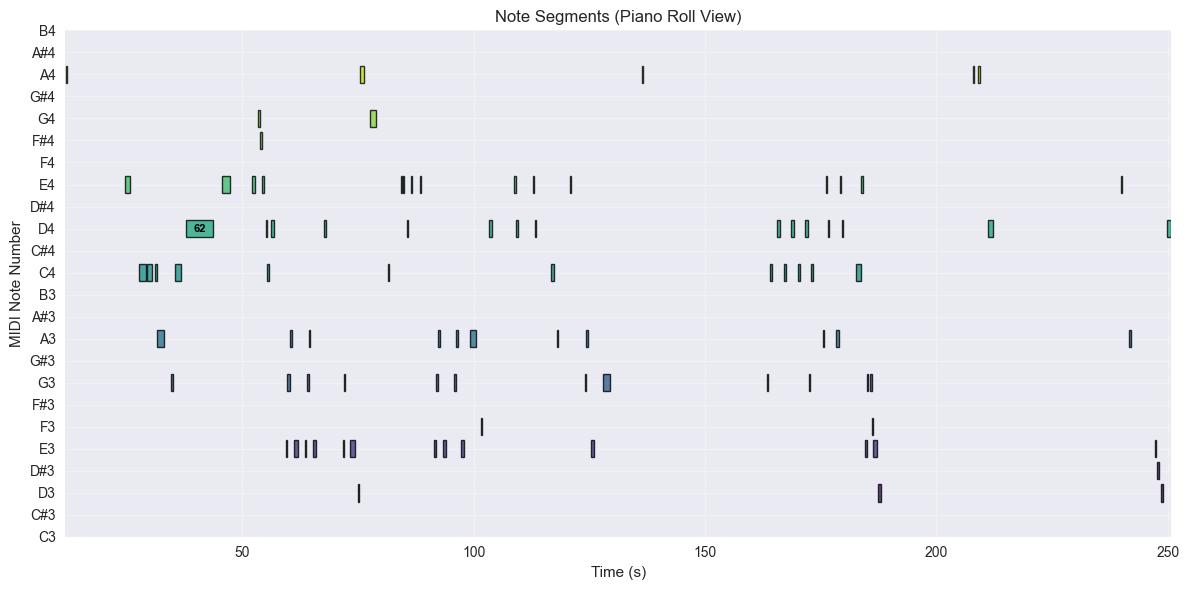

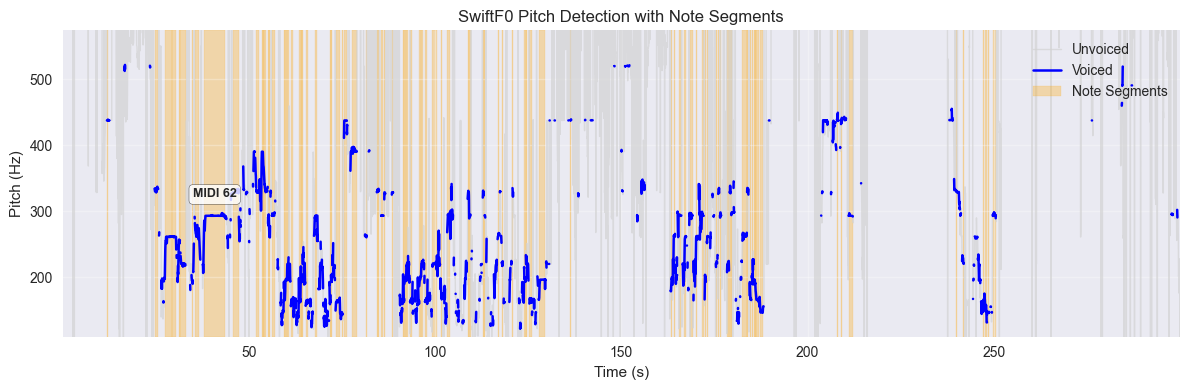

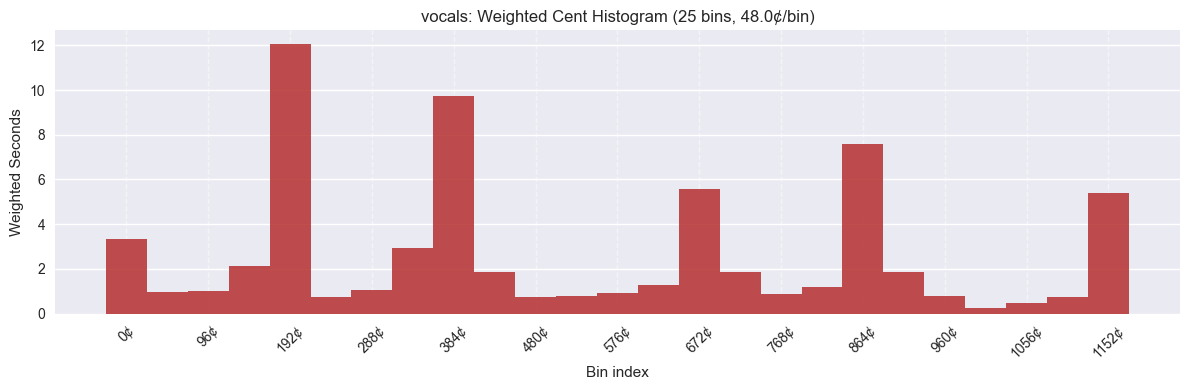

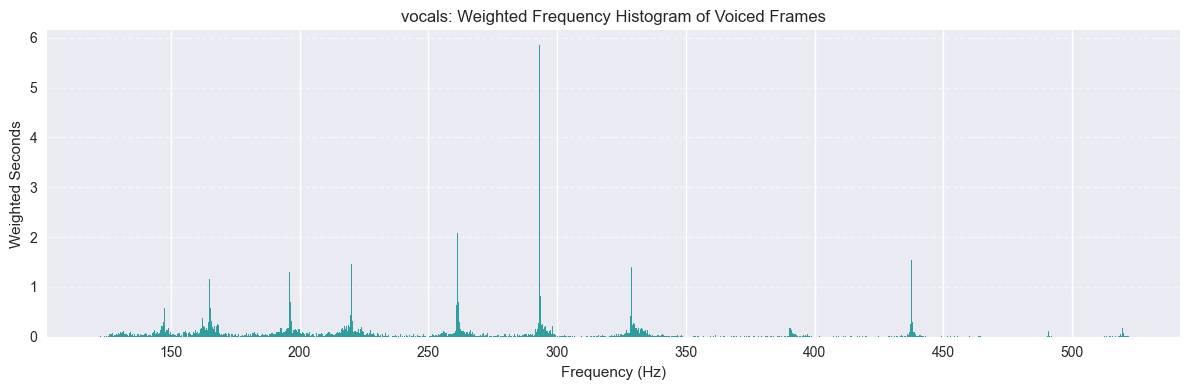

-------Accompaniment analysis --------


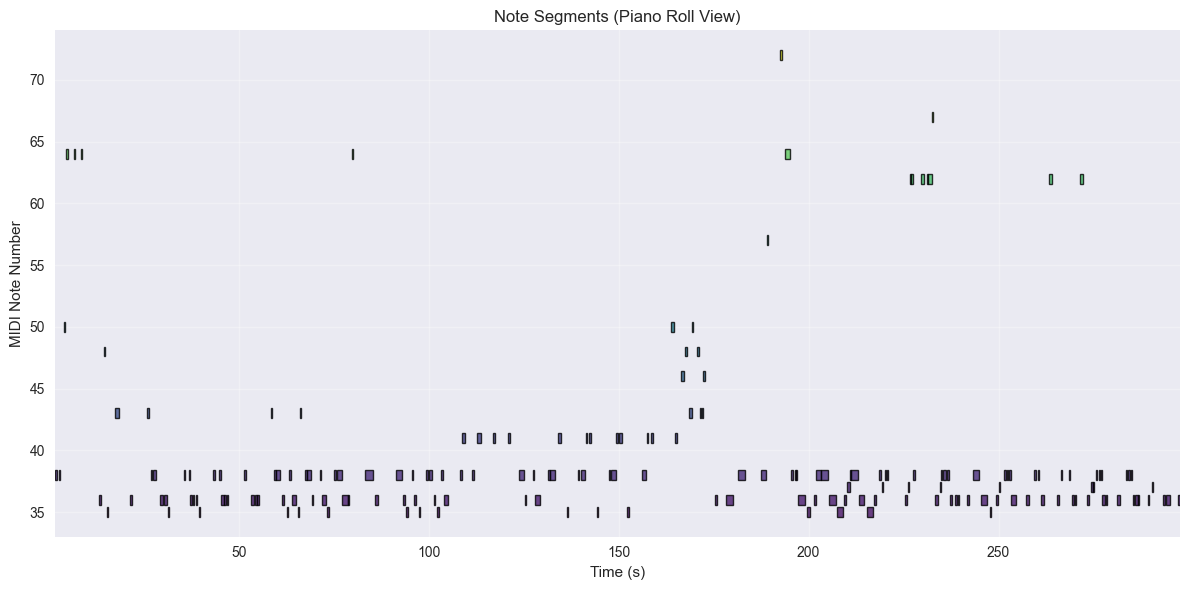

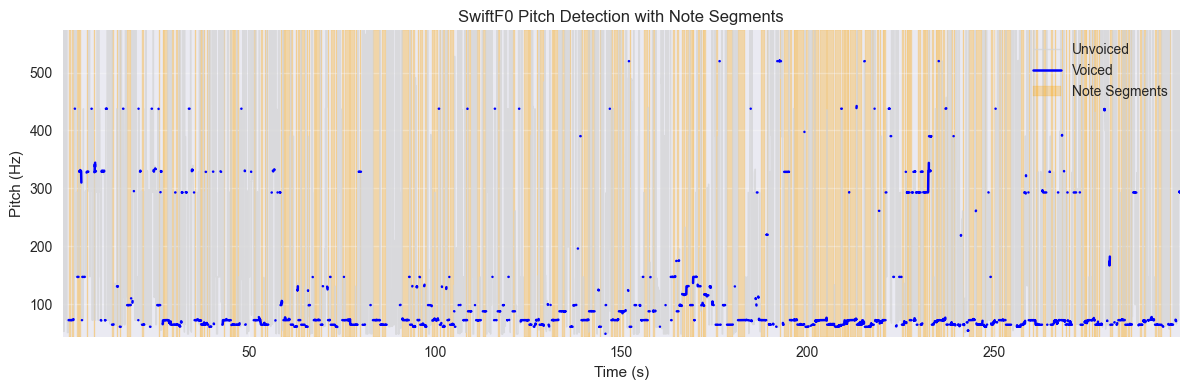

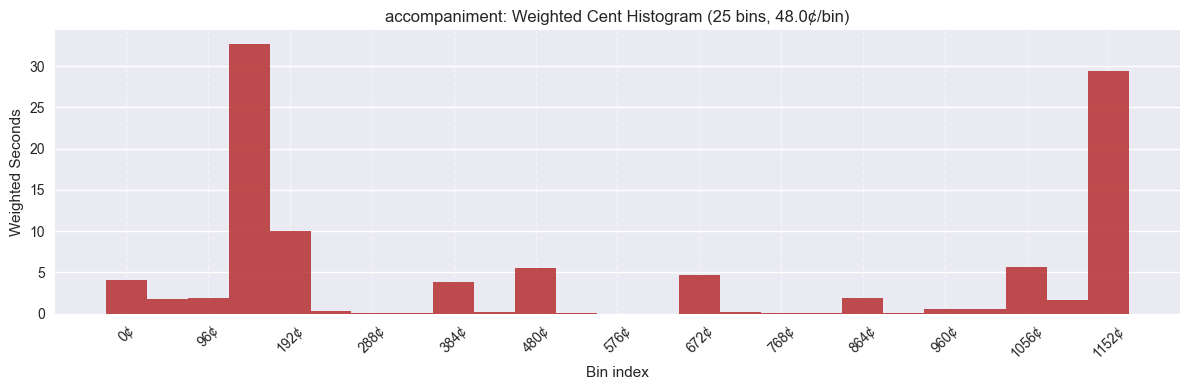

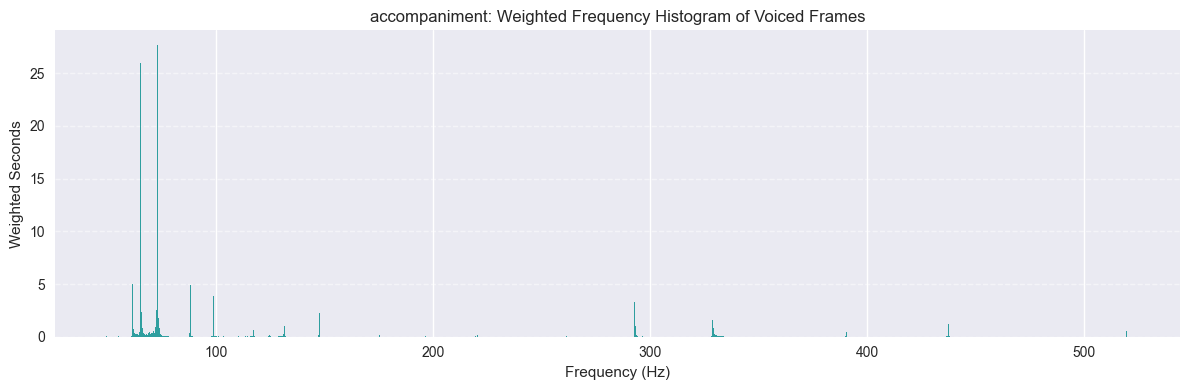

In [136]:
def analyze_audio_stem(stem_path, detector, output_prefix="output", num_bins=25):
    y, sr = librosa.load(stem_path, sr=None, duration=300.0)
    result = detector.detect_from_array(y, sr)

    # 1. Pitch plots + CSV
    plot_pitch(result, show=False, output_path=f"{output_prefix}_pitch.jpg")
    export_to_csv(result, f"{output_prefix}_pitch_data.csv")

    # 2. Note segmentation
    notes = segment_notes(
        result,
        split_semitone_threshold=0.8,
        min_note_duration=0.25
    )
    plot_notes(notes, output_path=f"{output_prefix}_note_segments.jpg")
    plot_pitch_and_notes(result, notes, output_path=f"{output_prefix}_combined_analysis.jpg")
    export_to_midi(notes, f"{output_prefix}_notes.mid")

    # 3. Extract voiced pitch/confidence
    voiced_mask = result.voicing
    voiced_frequencies = result.pitch_hz[voiced_mask]
    voiced_confidences = result.confidence[voiced_mask]

    # remove unvoiced / invalid
    valid_mask = voiced_frequencies > 0
    valid_frequencies = voiced_frequencies[valid_mask]
    valid_confidences = voiced_confidences[valid_mask]

    # frame duration from SwiftF0
    frame_duration = getattr(result, "frame_period", 1.0 / sr * 512)  # fallback if missing
    weights = valid_confidences * frame_duration

    # 4. Weighted cent histogram
    midi_vals = librosa.hz_to_midi(valid_frequencies)
    cent_values = (midi_vals % 12) * 100   # fold into one octave
    cent_hist, _ = np.histogram(
        cent_values,
        bins=num_bins,
        range=(0, 1200),
        weights=weights
    )
    bin_width = 1200 / num_bins

    # Weighted cent histogram
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(num_bins), cent_hist, width=1.0, color='firebrick', alpha=0.8)
    plt.title(f"{output_prefix}: Weighted Cent Histogram ({num_bins} bins, {bin_width:.1f}¢/bin)")
    plt.xlabel("Bin index")
    plt.ylabel("Weighted Seconds")
    step = max(1, num_bins // 12)
    ticks = np.arange(0, num_bins, step)
    labels = [f"{int(i * bin_width)}¢" for i in ticks]
    plt.xticks(ticks=ticks, labels=labels, rotation=45)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_cent_histogram.jpg")
    plt.show()   # <--- display it
    plt.close()

    # Weighted frequency histogram
    plt.figure(figsize=(12, 4))
    plt.hist(
        valid_frequencies,
        bins=1200,
        color='darkcyan',
        alpha=0.8,
        weights=weights
    )
    plt.title(f"{output_prefix}: Weighted Frequency Histogram of Voiced Frames")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weighted Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_frequency_histogram.jpg")
    plt.show()   # <--- display it
    plt.close()


    if output_prefix == "vocals":
        return notes, result, valid_frequencies, cent_hist
    else:
        return notes, result, valid_frequencies


min_note_str = 'G1'
max_note_str = 'C5'
fmin_hz = librosa.note_to_hz(min_note_str)
fmax_hz = librosa.note_to_hz(max_note_str)
detector = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.98)

print("-------Vocal analysis--------")
vocals_notes, result_v, valid_freqs_v, cent_hist_v = analyze_audio_stem(
    vocals_path,
    detector,
    output_prefix="vocals"
)

min_note_str = 'G1'
max_note_str = 'C5'
fmin_hz = librosa.note_to_hz(min_note_str)
fmax_hz = librosa.note_to_hz(max_note_str)
detector = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.8)

print("-------Accompaniment analysis --------")
accompaniment_notes, result_a, valid = analyze_audio_stem(
    accompaniment_path,
    detector,
    output_prefix="accompaniment"
)

# if accompaniment came back empty, retry with a lower confidence threshold
if not accompaniment_notes:
    print("No accompaniment notes found; lowering confidence threshold")
    fmin_hz = 65.0   
    fmax_hz = 2093.75
    detector = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.8)
    accompaniment_notes, result_a, valid = analyze_audio_stem(
        accompaniment_path,
        detector,
        output_prefix="accompaniment"
    )
    if accompaniment_notes:
        print(f"retry succeeded: found {len(accompaniment_notes)} notes.")
    else:
        print("Retry still returned no notes.")

Successfully built the new interval-based rāga database.
Computed high-resolution histogram with shape: (100,)
Computed low-resolution histogram with shape: (25,)
Generating histogram plot with ±35¢ note center zones...


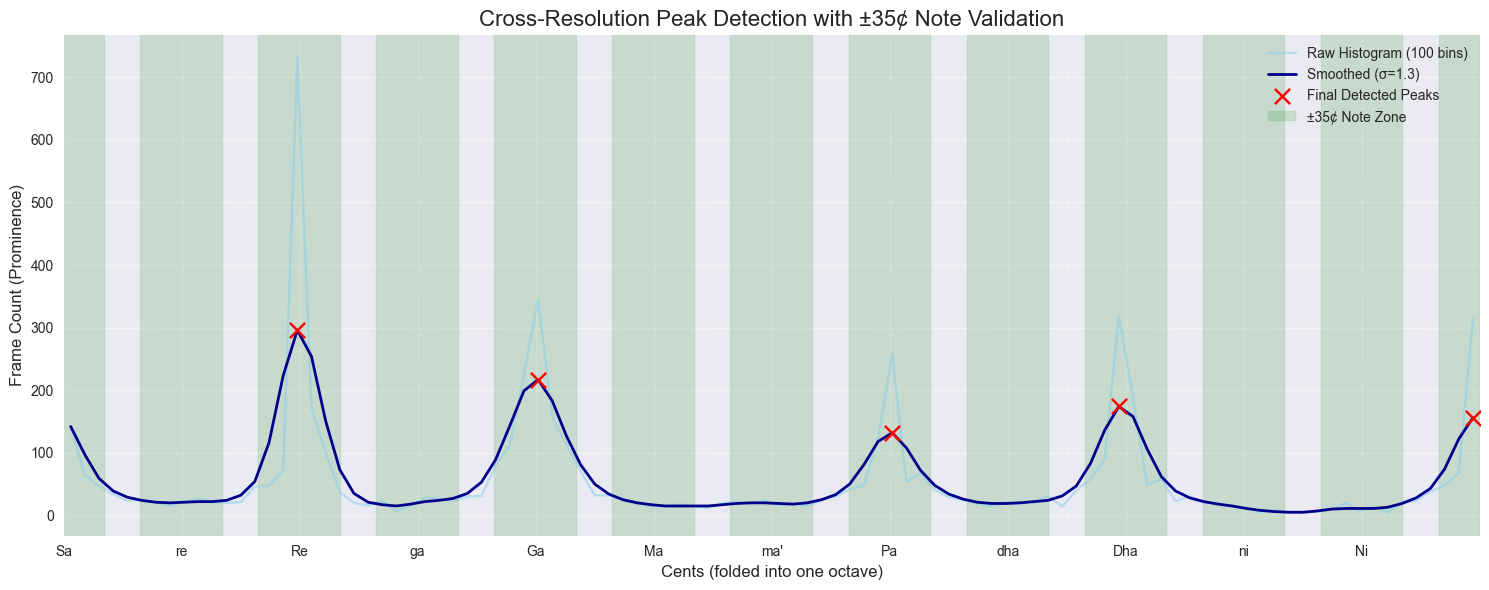


Found 5 precise peaks (100-bin) and 5 stable regions (25-bin).
Validated 5 final peaks.
Pitch-class candidates passed to next stage (±35¢ rule): [0, 2, 4, 7, 9]


In [137]:
import librosa
from collections import defaultdict

# The canonical form is the lexicographically smallest rotation of the pattern.
def get_canonical_intervals(intervals):
    if not isinstance(intervals, tuple) or not intervals:
        return tuple()
    return min(tuple(np.roll(intervals, i)) for i in range(len(intervals)))

# Load the processed rāga hash table
# This path should be the same as in your original code
raga_df = pd.read_csv('/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/raga_list_final.csv')

#Build a new lookup: canonical interval pattern → list of matching rāgas
# Each rāga is stored as a dictionary containing its name and specific interval pattern
raga_interval_db = defaultdict(list)

for _, row in raga_df.iterrows():
    if 'mask' in raga_df.columns:
        mask_abs = tuple(map(int, row['mask'].split(',')))
        name = row['raga']
    else:
        mask_abs = tuple(int(row[str(i)]) for i in range(12))
        name = row['names']

    # Get the pitch classes (swaras) from the rāga's definition
    p = np.where(np.array(mask_abs) == 1)[0]
    if len(p) < 2:  # Rāga needs at least two notes
        continue
    
    p.sort()
    # Calculate the rāga's specific interval pattern
    intervals = tuple(np.mod(np.diff(np.concatenate((p, [p[0] + 12]))), 12))

    # Ensure the scale is valid (intervals sum to an octave)
    if sum(intervals) != 12:
        continue

    # Find the canonical representation for this rāga's scale structure
    canonical_pattern = get_canonical_intervals(intervals)
    
    # Store the rāga's info under its canonical pattern
    raga_interval_db[canonical_pattern].append({'name': name, 'intervals': intervals})

# For compatibility with subsequent cells, we rename our new db.
# The original 'raga_masks' is no longer used in its old form.
raga_masks = raga_interval_db
print("Successfully built the new interval-based rāga database.")

# MODIFIED Cell 6: Compute both High- and Low-Resolution Histograms

# --- Settings for peak detection ---
num_bins_high_res = 100   # For precise, smoothed peak finding
num_bins_low_res = 25     # For stable, raw peak region finding
sigma = 1.3              # Smoothing amount for the high-res histogram
peak_tolerance_cents = 30 # How close a high-res peak must be to a low-res peak (in cents)

# --- Histogram Calculations ---
midi_vals_mel = librosa.hz_to_midi(valid_freqs_v)
cent_values = (midi_vals_mel % 12) * 100

# Create the high-resolution histogram (100 bins)
H_mel_100, bin_edges_100 = np.histogram(cent_values, bins=num_bins_high_res, range=(0, 1200))

# Create the low-resolution histogram (25 bins)
H_mel_25, bin_edges_25 = np.histogram(cent_values, bins=num_bins_low_res, range=(0, 1200))

print(f"Computed high-resolution histogram with shape: {H_mel_100.shape}")
print(f"Computed low-resolution histogram with shape: {H_mel_25.shape}")

# Cell 7: Detect peaks to get pitch-class candidates
# REPLACEMENT for Cell 7: Cross-Resolution Peak Detection and Visualization

from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# --- Part A: Find Peaks in Both Histograms and Convert to Cents ---

# 1. Process the HIGH-RESOLUTION histogram to get precise peak candidates
smoothed_H_100 = gaussian_filter1d(H_mel_100, sigma=sigma, mode='wrap')
bin_centers_100 = (bin_edges_100[:-1] + bin_edges_100[1:]) / 2
smoothed_peaks_100_indices = []
for i in range(num_bins_high_res):
    prev, next = (i - 1) % num_bins_high_res, (i + 1) % num_bins_high_res
    if smoothed_H_100[i] > smoothed_H_100[prev] and smoothed_H_100[i] > smoothed_H_100[next]:
        smoothed_peaks_100_indices.append(i)
# Get the cent values of these precise peaks
smoothed_peaks_cents = bin_centers_100[smoothed_peaks_100_indices]

# 2. Process the LOW-RESOLUTION histogram to get stable validation regions
bin_centers_25 = (bin_edges_25[:-1] + bin_edges_25[1:]) / 2
raw_peaks_25_indices = []
for i in range(num_bins_low_res):
    prev, next = (i - 1) % num_bins_low_res, (i + 1) % num_bins_low_res
    if H_mel_25[i] > H_mel_25[prev] and H_mel_25[i] > H_mel_25[next]:
        raw_peaks_25_indices.append(i)
# Get the cent values of these stable peaks
raw_peaks_cents = bin_centers_25[raw_peaks_25_indices]


# --- CONFIG (shared for all sections) ---
note_centers = np.arange(0, 1200, 100)  # Sa, re, Re, etc.
tolerance_cents = 35
peak_tolerance_cents = 30  # low/high-res match tolerance

# --- Part B: Validate Precise Peaks using Stable Peaks + ±35¢ Note Center Rule ---
final_peak_indices_100 = []
for i, sp_cent in zip(smoothed_peaks_100_indices, smoothed_peaks_cents):
    # Step 1: Check against stable low-res peaks
    is_validated = any(abs(sp_cent - rp_cent) <= peak_tolerance_cents for rp_cent in raw_peaks_cents)
    if not is_validated:
        continue

    # Step 2: Check against nearest ideal note center (±35¢ circular)
    diffs = np.abs((sp_cent - note_centers + 600) % 1200 - 600)
    if np.min(diffs) <= tolerance_cents:
        final_peak_indices_100.append(i)

# --- Part C: Visualization with ±35¢ Note Center Bands ---
print("Generating histogram plot with ±35¢ note center zones...")

sargam_labels = ["Sa", "re", "Re", "ga", "Ga", "Ma", "ma'", "Pa", "dha", "Dha", "ni", "Ni"]
plt.figure(figsize=(15, 6))

# Plot the high-resolution data (raw and smoothed)
plt.plot(bin_centers_100, H_mel_100, color='skyblue', alpha=0.5, label='Raw Histogram (100 bins)')
plt.plot(bin_centers_100, smoothed_H_100, color='darkblue', linewidth=2, label=f'Smoothed (σ={sigma})')

# Plot the final validated peaks
peak_x_values = bin_centers_100[final_peak_indices_100]
peak_y_values = smoothed_H_100[final_peak_indices_100]
plt.scatter(peak_x_values, peak_y_values, color='red', s=120, marker='x', 
            zorder=5, label='Final Detected Peaks')

# Draw ±35¢ shaded bands for each note center
for idx, center in enumerate(note_centers):
    low = (center - tolerance_cents) % 1200
    high = (center + tolerance_cents) % 1200
    if low < high:
        plt.axvspan(low, high, color='green', alpha=0.15, label='±35¢ Note Zone' if idx == 0 else "")
    else:
        plt.axvspan(0, high, color='green', alpha=0.15, label='±35¢ Note Zone' if idx == 0 else "")
        plt.axvspan(low, 1200, color='green', alpha=0.15)

plt.title("Cross-Resolution Peak Detection with ±35¢ Note Validation", fontsize=16)
plt.xlabel("Cents (folded into one octave)", fontsize=12)
plt.ylabel("Frame Count (Prominence)", fontsize=12)
plt.xticks(ticks=np.arange(0, 1200, 100), labels=sargam_labels)
plt.grid(True, linestyle='--', alpha=0.6)

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlim(0, 1200)
plt.tight_layout()
plt.show()

# --- Part D: Final Output for Downstream Cells ---
final_peak_cents = bin_centers_100[final_peak_indices_100]
pc_cand = set()

for cent_val in final_peak_cents:
    diffs = np.abs((cent_val - note_centers + 600) % 1200 - 600)  # circular diff
    nearest_idx = np.argmin(diffs)
    if diffs[nearest_idx] <= tolerance_cents:
        pc_cand.add(nearest_idx % 12)  # pitch class index

pc_cand = sorted(pc_cand)

print(f"\nFound {len(smoothed_peaks_cents)} precise peaks (100-bin) and {len(raw_peaks_cents)} stable regions (25-bin).")
print(f"Validated {len(final_peak_indices_100)} final peaks.")
print(f"Pitch-class candidates passed to next stage (±{tolerance_cents}¢ rule): {pc_cand}")



In [138]:
# Cell 8: Build interval sequence from detected pitch-classes
P = np.array(pc_cand)
p = np.sort(P)
k = len(p)
intervals = np.mod(np.diff(np.concatenate((p, [p[0]+12]))), 12)
print(f"Detected intervals: {intervals}")

# Helper function (repeat from above, or define in a shared cell)
def get_canonical_intervals(intervals):
    if not isinstance(intervals, tuple) or not intervals:
        return tuple()
    return min(tuple(np.roll(intervals, i)) for i in range(len(intervals)))

dx_candidates = []  # list of (tonic, mask_rel, ragas)

# p is the sorted list of detected pitch classes from Cell 8
# intervals is the detected interval sequence from Cell 8
# k is the number of detected pitch classes from Cell 8
for j in range(k):
    tonic = int(p[j])
    # Consider each possible rotation of the detected intervals
    rotated_I = tuple(np.roll(intervals, -j))
    
    # Find the canonical form of the detected interval pattern
    canonical_I = get_canonical_intervals(rotated_I)

    # Look for this scale structure in our new database
    if canonical_I in raga_masks:
        # We found a potential match! Now, find the specific rāgas.
        # 'raga_group' contains all rāgas matching the canonical pattern (e.g., Bhupali, Dhani)
        raga_group = raga_masks[canonical_I]
        
        # Check which of these rāgas has the exact interval pattern we just detected
        matching_ragas = [
            raga['name'] for raga in raga_group 
            if raga['intervals'] == rotated_I
        ]
        
        if matching_ragas:
            # We have a valid candidate. Now, construct the relative mask
            # that subsequent cells expect.
            current_note = 0
            # Notes relative to the tonic at 0
            relative_notes = {0}
            for step in rotated_I[:-1]:
                current_note += step
                relative_notes.add(current_note)
            
            mask_rel = tuple(1 if i in relative_notes else 0 for i in range(12))
            
            # Add the found candidate(s) to our list
            dx_candidates.append((tonic, mask_rel, matching_ragas))

print(f"Valid interval-based inversions: {[(t, ragas) for t,_,ragas in dx_candidates]}")

# Cell 10: Compute accompaniment tonic salience for these tonics
midi_vals_acc = librosa.hz_to_midi(valid)
pitch_classes_acc = np.mod(np.round(midi_vals_acc), 12).astype(int)
H_acc, _ = np.histogram(pitch_classes_acc, bins=12, range=(0,12))
a_theta = {t: np.roll(H_acc, -t)[0] for t,_,_ in dx_candidates}
print(f"Accompaniment salience per tonic: {a_theta}")
Theta_prime = [t for t,a in a_theta.items() if a >= 0]

results = []
# Pre-aggregate melody histogram from high-resolution bins to 12 pitch classes
H_pc = np.zeros(12, dtype=int)
# cent_to_pc is from the peak detection cell (Cell 7)
# H_mel_100 is from the histogram creation cell (Cell 6)
for bin_index, pc in enumerate(cent_to_pc):
    H_pc[pc] += H_mel_100[bin_index] # CORRECTED

for tonic, mask_rel, ragas in dx_candidates:
    # Skip candidates whose tonic has weak support from the accompaniment
    if tonic not in Theta_prime:
        continue
    
    # create Sa-relative view of the melody's pitch distribution
    H_rot = np.roll(H_pc, -tonic)
        
    # bonus for the tonic (Sa) is always its count in the melody
    sa_bonus = H_rot[0]
    
    bonus_options = [0] # Start with 0 in case rāga has no Ma or Pa.
    if mask_rel[5] == 1:  # Check for Shuddha Ma
        bonus_options.append(H_rot[5])
    if mask_rel[6] == 1:  # Check for Tivra Ma
        bonus_options.append(H_rot[6])
    if mask_rel[7] == 1:  # Check for Pa
        bonus_options.append(H_rot[7])
    
    dominant_note_bonus = max(bonus_options)
    

    score = sa_bonus + dominant_note_bonus
        
    for raga in ragas:
        results.append({'tonic': tonic, 'raga': raga,
                        'score': score, 'salience': a_theta[tonic]})

#results sorted by Salience, then Score

if results:
    df = pd.DataFrame(results)
    print("Top 10 Rāga Candidates (Ranked by Tonic Salience, then Score):")
    
    final_ranking = df.sort_values(by=['salience', 'score'], ascending=[False, False])
    
    print(final_ranking.head(10))
else:
    print(" No matching ragas were found in the database.")

Detected intervals: [2 2 3 2 3]
Valid interval-based inversions: [(0, ['["Bhupali, Deshkar, Pahadi"]']), (2, ['["Madhumad Sarang, Megh"]']), (4, ['["Malkauns"]']), (7, ['["Durga, Jaldhar Kedar"]']), (9, ['["Dhani"]'])]
Accompaniment salience per tonic: {0: 3033, 2: 3860, 4: 368, 7: 457, 9: 183}
Top 10 Rāga Candidates (Ranked by Tonic Salience, then Score):
   tonic                          raga  score  salience
1      2     ["Madhumad Sarang, Megh"]   2075      3860
0      0  ["Bhupali, Deshkar, Pahadi"]   1417      3033
3      7      ["Durga, Jaldhar Kedar"]   1911       457
2      4                  ["Malkauns"]   1993       368
4      9                     ["Dhani"]   2075       183


In [139]:
import pandas as pd
import numpy as np
from collections import defaultdict

unsupported_note_penalty = 500

all_candidates = {}

for j in range(k):
    tonic = int(p[j])
    rotated_I = tuple(np.roll(intervals, -j))
    canonical_I = get_canonical_intervals(rotated_I)
    
    if canonical_I in raga_masks:
        raga_group = raga_masks[canonical_I]
        matching_ragas = [raga['name'] for raga in raga_group if raga['intervals'] == rotated_I]
        for raga_name in matching_ragas:
            raga_row = raga_df[raga_df['names'] == raga_name]
            if not raga_row.empty:
                mask_abs = tuple(int(raga_row.iloc[0][str(i)]) for i in range(12))
                all_candidates[raga_name] = mask_abs

detected_mask = np.zeros(12, dtype=int)
if pc_cand:
    detected_mask[pc_cand] = 1

for i in range(12):
    neighbor_mask = detected_mask.copy()
    neighbor_mask[i] = 1 - neighbor_mask[i]
    
    neighbor_p = np.where(neighbor_mask == 1)[0]
    if len(neighbor_p) < 2: continue
    
    neighbor_intervals = np.mod(np.diff(np.concatenate((neighbor_p, [neighbor_p[0]+12]))), 12)
    
    for j_neighbor in range(len(neighbor_p)):
        rotated_I = tuple(np.roll(neighbor_intervals, -j_neighbor))
        canonical_I = get_canonical_intervals(rotated_I)
        
        if canonical_I in raga_masks:
            raga_group = raga_masks[canonical_I]
            matching_ragas = [raga['name'] for raga in raga_group if raga['intervals'] == rotated_I]
            for raga_name in matching_ragas:
                if raga_name not in all_candidates:
                    raga_row = raga_df[raga_df['names'] == raga_name]
                    if not raga_row.empty:
                        mask_abs = tuple(int(raga_row.iloc[0][str(i)]) for i in range(12))
                        all_candidates[raga_name] = mask_abs

final_results = []
if all_candidates:
    pitch_classes_acc = np.mod(np.round(midi_vals_acc), 12).astype(int)
    H_acc, _ = np.histogram(pitch_classes_acc, bins=12, range=(0,12))
    salience_all_tonics = {t: H_acc[t] for t in range(12)}
    detected_notes_set = set(pc_cand)
    
    for raga_name, mask_abs_tuple in all_candidates.items():
        mask_abs = np.array(mask_abs_tuple)
        raga_notes_abs_set = {i for i, present in enumerate(mask_abs) if present}

        for tonic in range(12):
            H_rot = np.roll(H_pc, -tonic)
            mask_rel = np.roll(mask_abs, -tonic)
            
            salience = salience_all_tonics.get(tonic, 0)
            
            sa_bonus = H_rot[0]
            bonus_options = [0]
            if mask_rel[5] == 1: bonus_options.append(H_rot[5])
            if mask_rel[6] == 1: bonus_options.append(H_rot[6])
            if mask_rel[7] == 1: bonus_options.append(H_rot[7])
            primary_score = sa_bonus + max(bonus_options)
            
            # --- Normalized + symmetric fit score (drop-in replacement) ---
            # reward: sum of observed salience on the raga notes (tonic-relative)
            reward = float(sum(H_rot[i] for i, present in enumerate(mask_rel) if present))

            # normalize reward by total observed vocal salience under this tonic
            total_salience = float(np.sum(H_rot)) if np.sum(H_rot) > 0 else 1.0
            reward_norm = reward / total_salience  # in [0,1] roughly

            # missing and extra notes (proportions)
            missing_notes = raga_notes_abs_set - detected_notes_set
            missing_prop = len(missing_notes) / max(1, len(raga_notes_abs_set))  # fraction of raga notes missing

            extra_notes = detected_notes_set - raga_notes_abs_set
            extra_prop = len(extra_notes) / 12.0  # fraction of chromatic pcs that are extra

            # weights (tunable). Missing should be penalized more than extras usually.
            MISSING_WEIGHT = 0.6
            EXTRA_WEIGHT = 0.4

            fit_score_norm = reward_norm - (MISSING_WEIGHT * missing_prop) - (EXTRA_WEIGHT * extra_prop)

            # scale to original-ish numeric range so comparisons/sorting behave similarly
            fit_score = float(fit_score_norm * 1000.0)

            
            final_results.append({
                'raga': raga_name,
                'tonic': tonic,
                'salience': salience,
                'fit_score': fit_score,
                'primary_score': primary_score
            })

if final_results:
    df_final = pd.DataFrame(final_results)
    
    final_ranking = df_final.sort_values(
        by=['salience', 'fit_score', 'primary_score'],
        ascending=[False, False, False]
    )
    
    print(final_ranking.head(50))
else:
    print("Analysis complete: No plausible rāga candidates were found.")

                             raga  tonic  salience   fit_score  primary_score
2    ["Bhupali, Deshkar, Pahadi"]      2      3860  814.051031           2075
62                      [“Jayat"]      2      3860  744.459979           2075
146                  ["Shankara"]      2      3860  732.401258           2075
110                   [“Deshkar”]      2      3860  562.612140           2075
38       ["Durga, Jaldhar Kedar"]      2      3860  482.807876           2075
158   ["Gorakh Kalyan, Narayani"]      2      3860  423.604800           2075
14      ["Madhumad Sarang, Megh"]      2      3860  205.741582           1911
122     ["Marwa, Puriya, Sohini"]      2      3860  189.782127           2075
134             ["Nayaki Kanada"]      2      3860  174.927182           1911
86                     ["Sarang"]      2      3860  164.091809           1911
98                        ["Jog"]      2      3860  160.596528           1911
182                ["Mohankauns"]      2      3860  -54.875918  